In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ot 

np.random.seed(42)

In [3]:
grid = np.linspace(-4, 8, 500)  # 500 points from -4 to 8

def normal_pdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

mu0, sigma0 = 0, 1
muT, sigmaT = 2, 1

p0 = normal_pdf(grid, mu0, sigma0)
pT = normal_pdf(grid, muT, sigmaT)

p0 /= np.sum(p0)
pT /= np.sum(pT)

# Compute the Entropic OT Coupling using Sinkhorn (IPF)
X, Y = np.meshgrid(grid, grid)
cost_matrix = (X - Y) ** 2

epsilon = 0.01   # Entropic regularization parameter
coupling = ot.sinkhorn(p0, pT, cost_matrix, reg=epsilon)
transport_map = (coupling @ grid) / (np.maximum(np.sum(coupling, axis=1), 1e-10))

/n/home03/ahmadazim/.conda/envs/bridge/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:631: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/n/home03/ahmadazim/.conda/envs/bridge/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 62
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


In [4]:
# Flow Matching: Theoretical (Deterministic) Transport Map
flow_map = grid + (muT - mu0)

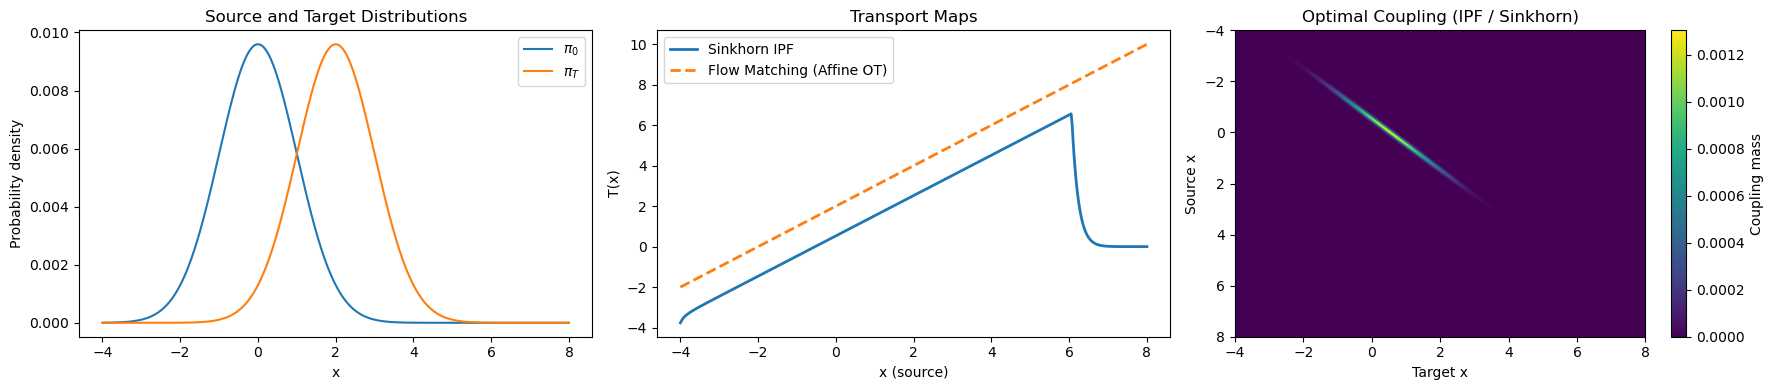

In [24]:
plt.figure(figsize=(18, 4))

# Plot the source and target distributions
plt.subplot(1, 3, 1)
plt.plot(grid, p0, label=r'$\pi_0$')
plt.plot(grid, pT, label=r'$\pi_T$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.title('Source and Target Distributions')
plt.legend()

# Plot the transport maps
plt.subplot(1, 3, 2)
plt.plot(grid, transport_map, label='Sinkhorn IPF', lw=2)
plt.plot(grid, flow_map, label='Flow Matching (Affine OT)', lw=2, linestyle='--')
plt.xlabel('x (source)')
plt.ylabel('T(x)')
plt.title('Transport Maps')
plt.legend()

# Visualize the coupling
plt.subplot(1, 3, 3)
plt.imshow(coupling, aspect='auto', extent=[grid[0], grid[-1], grid[-1], grid[0]])
plt.xlabel('Target x')
plt.ylabel('Source x')
plt.title('Optimal Coupling (IPF / Sinkhorn)')
plt.colorbar(label='Coupling mass')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# 1. Define the Distributions
# -------------------------
def sample_pi0(batch_size):
    # Source distribution: N((-2, 0), I)
    return torch.randn(batch_size, 2, device=device) + torch.tensor([-2.0, 0.0], device=device)

def sample_pi1(batch_size):
    # Target distribution: N((2, 0), I)
    return torch.randn(batch_size, 2, device=device) + torch.tensor([2.0, 0.0], device=device)

# -------------------------
# 2. Brownian Bridge Interpolant Function
# -------------------------
def brownian_bridge(x0, x1, t, eps=1.0):
    """
    Given x0, x1 of shape [B,2] and time t (scalar or tensor of shape [B,1]),
    return the interpolated point using:
       x_t = (1-t)x0 + t x1 + sqrt(eps*t*(1-t))*z,
    where z ~ N(0,I).
    """
    if not torch.is_tensor(t):
        t = torch.tensor([t], device=device).expand(x0.shape[0], 1)
    else:
        # Ensure t is 2D: if t is 1D, unsqueeze it
        if t.dim() == 1:
            t = t.unsqueeze(1)
    x_linear = (1 - t) * x0 + t * x1
    noise_std = torch.sqrt(eps * t * (1 - t))
    z = torch.randn_like(x0)
    return x_linear + noise_std * z

# -------------------------
# 3. Define the Neural Network v_theta(t, x)
# -------------------------
class DriftNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=2):
        super(DriftNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, t, x):
        # Ensure t is 2D: if t is 1D, unsqueeze it.
        if t.dim() == 1:
            t = t.unsqueeze(1)
        # x is expected to be [B,2]; t now is [B,1]
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

# -------------------------
# 4. Define the Loss Function
# -------------------------
def compute_loss(model, x0, x1, t, eps=1.0):
    # Generate x_t using the Brownian bridge
    x_t = brownian_bridge(x0, x1, t, eps)
    # Get drift prediction from the model
    v_pred = model(t, x_t)
    # Target drift: (x1 - x_t) / (1-t)
    target = (x1 - x_t) / (1 - t)
    loss = ((v_pred - target)**2).mean()
    return loss

# -------------------------
# 5. Training Loop (Online α-DSBM)
# -------------------------
def train_alpha_dsbm(model, num_steps=10000, batch_size=256, eps=1.0, alpha_step=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []
    for step in range(num_steps):
        model.train()
        x0 = sample_pi0(batch_size)
        x1 = sample_pi1(batch_size)
        # Sample time t uniformly from (0,1); shape [B,1]
        t = torch.rand(batch_size, 1, device=device)
        loss = compute_loss(model, x0, x1, t, eps)
        optimizer.zero_grad()
        loss.backward()
        # Scale gradients by alpha_step (incremental update)
        for param in model.parameters():
            param.grad.data.mul_(alpha_step)
        optimizer.step()
        loss_history.append(loss.item())
        if (step + 1) % 1000 == 0:
            print(f"Step {step+1}/{num_steps}, Loss: {loss.item():.4f}")
    return loss_history

# -------------------------
# 6. Sampling Trajectories
# -------------------------
def sample_trajectory(model, x0, x1, eps=1.0, num_steps=50):
    """
    Given endpoints x0 and x1 (each shape [1,2]), generate a trajectory by using Euler's method
    for the probability flow ODE:
       dx/dt = v(t, x)
    """
    ts = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1, 1)  # shape [num_steps,1]
    trajectory = []
    # Initialize using Brownian bridge interpolation at t=0 (should be x0)
    xt = brownian_bridge(x0, x1, ts[0], eps)
    trajectory.append(xt.detach().cpu().numpy())
    dt = 1.0 / (num_steps - 1)
    with torch.no_grad():
        for t in ts[:-1]:
            # Ensure t is 2D
            if t.dim() == 1:
                t = t.unsqueeze(0)
            v = model(t, xt)  # predicted drift; xt shape [1,2]
            xt = xt + v * dt  # Euler step
            trajectory.append(xt.detach().cpu().numpy())
    return np.concatenate(trajectory, axis=0)  # shape [num_steps,2]

# -------------------------
# 7. Putting it All Together
# -------------------------
# Hyperparameters
eps = 1.0         # Entropic regularization parameter for the bridge
alpha_step = 1e-3 # Incremental gradient step multiplier (our alpha)
num_steps_train = 10000
batch_size = 256

# Initialize the drift network
model = DriftNet(input_dim=3, hidden_dim=64, output_dim=2).to(device)

# Train the model using the online α-DSBM procedure
loss_history = train_alpha_dsbm(model, num_steps=num_steps_train, batch_size=batch_size, eps=eps, alpha_step=alpha_step)

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("α-DSBM Training Loss")
plt.show()

# Sample a few trajectories and plot them
model.eval()
num_traj = 5
trajectories = []
for i in range(num_traj):
    x0_sample = sample_pi0(1)  # shape [1,2]
    x1_sample = sample_pi1(1)  # shape [1,2]
    traj = sample_trajectory(model, x0_sample, x1_sample, eps, num_steps=50)
    trajectories.append(traj)

trajectories = np.array(trajectories)  # shape [num_traj, num_steps, 2]

plt.figure(figsize=(6,6))
for traj in trajectories:
    plt.plot(traj[:,0], traj[:,1], marker='o')
plt.scatter(-2, 0, color='red', label='pi0 mean')
plt.scatter(2, 0, color='blue', label='pi1 mean')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sampled Trajectories via α-DSBM")
plt.legend()
plt.grid(True)
plt.show()

Step 1000/10000, Loss: 13.1258
Step 2000/10000, Loss: 5.4708
Step 3000/10000, Loss: 8.0490
Step 4000/10000, Loss: 6.1051
Step 5000/10000, Loss: 8.1094
Step 6000/10000, Loss: 7.4667
Step 7000/10000, Loss: 8.7234
Step 8000/10000, Loss: 7.5340
Step 9000/10000, Loss: 4.7619


In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pi0: N( (-2,2), [[2,1],[1,2]] )
# pi1: N( (2,0), I )
pi0_mean = torch.tensor([-4.0, 2.0], device=device)
pi1_mean = torch.tensor([5.0, -3.0], device=device)
pi0_cov = torch.tensor([[3.0, 1.0], [1.0, 3.0]], device=device)
pi1_cov = torch.tensor([[2.0, -1.0], [-1.0, 2.0]], device=device)
pi0_L = torch.cholesky(pi0_cov)
pi1_L = torch.cholesky(pi1_cov)

def sample_pi0(batch_size):
    return torch.randn(batch_size, 2, device=device) @ pi0_L.T + pi0_mean

def sample_pi1(batch_size):
    return torch.randn(batch_size, 2, device=device) @ pi1_L.T + pi1_mean

# For plotting densities we also define a function to compute 2D Gaussian density.
def gaussian_density(x, mu, cov=np.eye(2)):
    # Convert torch tensors to numpy arrays if necessary.
    if isinstance(mu, torch.Tensor):
        mu = mu.cpu().numpy()
    if isinstance(cov, torch.Tensor):
        cov = cov.cpu().numpy()
    diff = np.array(x - mu)
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (2 * np.pi * np.sqrt(det_cov))
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    return norm_const * np.exp(exponent)

In [ ]:
# Brownian Bridge Interpolant
def interp(x0, x1, t, eps=1.0):
    """
    Interpolation operator: Given endpoints x0 and x1 (shape [B,2]) and time t (tensor shape [B,1]),
    return the interpolated point via the Brownian bridge formula:
         x_t = (1-t)*x0 + t*x1 + sqrt(eps*t*(1-t))*z,
    with z ~ N(0, I).
    """
    # x0, x1: [B,2] ; t: [B,1]
    x_linear = (1 - t) * x0 + t * x1
    noise_std = torch.sqrt(eps * t * (1 - t))
    z = torch.randn_like(x0)
    return x_linear + noise_std * z

# Define a bidirectional drift network v_theta(s,t,x)
class BidirectionalDriftNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        """
        Input dimension is 4 because we concatenate:
          - s: a binary scalar (0 or 1) indicating direction (forward: s=1, backward: s=0)
          - t: a scalar time (as a 1-dim vector)
          - x: a 2D point.
        """
        super(BidirectionalDriftNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, s, t, x):
        # Ensure t is 2D: if t is 1D, unsqueeze
        if t.dim() == 1:
            t = t.unsqueeze(1)
        # s is expected to be a tensor of shape [B,1]
        inp = torch.cat([s, t, x], dim=1)  # shape [B,4]
        return self.net(inp)

# EMA Update Function
def update_ema(model, ema_model, decay):
    """
    Update the EMA model parameters.
    For every parameter: ema_param <- decay * ema_param + (1-decay)*param.
    """
    with torch.no_grad():
        msd = model.state_dict()
        esd = ema_model.state_dict()
        for key in msd.keys():
            esd[key].mul_(decay).add_(msd[key] * (1 - decay))
        ema_model.load_state_dict(esd)

# Loss functions for pretraining (bidirectional)
def compute_bidirectional_loss(model, x0, x1, t, eps=1.0):
    """
    Compute bidirectional loss with loss scaling.
    
    For the forward branch (s=1): 
      x_t^f = (1-t)*x0 + t*x1 + sqrt(eps*t*(1-t))*z.
      Target drift: (x1 - x_t^f) / (1-t)
      Downweight with: w_fwd = 1/(1 + eps*t/(1-t))
      
    For the backward branch (s=0): 
      x_t^b = (1-t)*x1 + t*x0 + sqrt(eps*t*(1-t))*z.
      Target drift: (x0 - x_t^b) / (1-t)
      Downweight with: w_bwd = 1/(1 + eps*(1-t)/t)
    """
    # Forward branch
    x_t_f = interp(x0, x1, t, eps)
    s_f = torch.ones_like(t, device=device)  # s = 1
    v_f = model(s_f, t, x_t_f)
    target_f = (x1 - x_t_f) / (1 - t)
    # Compute weight: add a small constant to denominator for numerical stability.
    weight_fwd = 1 / (1 + eps * t / (1 - t + 1e-6))
    
    # Backward branch (swap endpoints)
    x_t_b = interp(x1, x0, t, eps)
    s_b = torch.zeros_like(t, device=device)  # s = 0
    target_b = (x0 - x_t_b) / (1 - t)
    v_b = model(s_b, t, x_t_b)
    weight_bwd = 1 / (1 + eps * (1 - t) / (t + 1e-6))
    
    loss_forward = (weight_fwd * ((v_f - target_f)**2)).mean()
    loss_backward = (weight_bwd * ((v_b - target_b)**2)).mean()
    return 0.5 * (loss_forward + loss_backward)

# Pretraining Stage
def pretraining_stage(model, ema_model, num_steps=5000, batch_size=256, eps=1.0, lr=1e-3, ema_decay=0.999):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    for step in range(num_steps):
        x0 = sample_pi0(batch_size)
        x1 = sample_pi1(batch_size)
        t = torch.rand(batch_size, 1, device=device)
        loss = compute_bidirectional_loss(model, x0, x1, t, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update EMA model after each optimizer step
        update_ema(model, ema_model, ema_decay)
        loss_hist.append(loss.item())
        if (step+1) % 1000 == 0:
            print(f"[Pretraining] Step {step+1}/{num_steps}, Loss: {loss.item():.4f}")
    return loss_hist

# Finetuning Stage (Online Bidirectional Updates)
def euler_step(x, drift, dt):
    # A simple Euler step for ODE simulation (deterministic)
    return x + drift * dt

def sample_trajectory_bidirectional(model, s_value, x_init, num_steps=50):
    """
    Simulate trajectory using the probability flow ODE.
    s_value: scalar tensor (1 for forward, 0 for backward).
    For forward: starting from x0.
    For backward: starting from x1.
    """
    ts = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1, 1)
    dt = 1.0 / (num_steps - 1)
    trajectory = []
    x = x_init.clone()
    trajectory.append(x.detach().cpu().numpy())
    with torch.no_grad():
        for t in ts[:-1]:
            drift = model(s_value, t.expand(x.shape[0], 1), x)
            x = euler_step(x, drift, dt)
            trajectory.append(x.detach().cpu().numpy())
    return np.concatenate(trajectory, axis=0)

def finetuning_stage(model, ema_model, num_steps=5000, batch_size=256, eps=1.0, lr=1e-4, alpha_step=1e-3, ema_decay=0.999):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    for step in range(num_steps):
        x0 = sample_pi0(batch_size)
        x1 = sample_pi1(batch_size)
        
        # Forward branch: s=1, from x0 to x1
        t_forward = torch.rand(batch_size, 1, device=device)
        x_t_forward = interp(x0, x1, t_forward, eps)
        s_forward = torch.ones_like(t_forward, device=device)
        v_forward = model(s_forward, t_forward, x_t_forward)
        target_forward = (x1 - x_t_forward) / (1 - t_forward)
        
        # Backward branch: s=0, from x1 to x0 (swap endpoints)
        t_backward = torch.rand(batch_size, 1, device=device)
        x_t_backward = interp(x1, x0, t_backward, eps)
        s_backward = torch.zeros_like(t_backward, device=device)
        v_backward = model(s_backward, t_backward, x_t_backward)
        target_backward = (x0 - x_t_backward) / (1 - t_backward)
        
        loss_forward = ((v_forward - target_forward)**2).mean()
        loss_backward = ((v_backward - target_backward)**2).mean()
        loss = 0.5 * (loss_forward + loss_backward)
        
        optimizer.zero_grad()
        loss.backward()
        # Scale gradients by alpha_step for incremental update
        for param in model.parameters():
            param.grad.data.mul_(alpha_step)
        optimizer.step()
        update_ema(model, ema_model, ema_decay)
        loss_hist.append(loss.item())
        if (step+1) % 1000 == 0:
            print(f"[Finetuning] Step {step+1}/{num_steps}, Loss: {loss.item():.4f}")
    return loss_hist

# Visualization

# def plot_density_contours():
#     # Create a grid over a 2D region.
#     x = np.linspace(-6, 6, 200)
#     y = np.linspace(-6, 6, 200)
#     X, Y = np.meshgrid(x, y)
#     grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape [N,2]
    
#     # Evaluate density for pi0 and pi1 (both Gaussians)
#     pi0_density = gaussian_density(grid_points, np.array([-2, 0]), sigma=1.0).reshape(X.shape)
#     pi1_density = gaussian_density(grid_points, np.array([2, 0]), sigma=1.0).reshape(X.shape)
    
#     plt.figure(figsize=(6,6))
#     plt.contour(X, Y, pi0_density, levels=10, cmap='Reds', alpha=0.5)
#     plt.contour(X, Y, pi1_density, levels=10, cmap='Blues', alpha=0.5)
#     plt.title("Density Contours of pi0 (red) and pi1 (blue)")
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.grid(True)
#     plt.show()

def plot_trajectories(model, ema_model, eps=1.0, num_steps=50, num_traj=5, use_ema=True):
    # We'll use the EMA model for sampling trajectories
    net = ema_model if use_ema else model
    traj_fwd_list = []
    traj_bwd_list = []
    for i in range(num_traj):
        x0_sample = sample_pi0(1)
        x1_sample = sample_pi1(1)
        traj_fwd = sample_trajectory_bidirectional(net, torch.ones(1,1, device=device), x0_sample, num_steps)
        traj_bwd = sample_trajectory_bidirectional(net, torch.zeros(1,1, device=device), x1_sample, num_steps)
        traj_fwd_list.append(traj_fwd)
        traj_bwd_list.append(traj_bwd)
    
    x = np.linspace(-10, 10, 200)
    y = np.linspace(-10, 10, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
    pi0_density = gaussian_density(grid_points, np.array(pi0_mean), cov=pi0_cov).reshape(X.shape)
    pi1_density = gaussian_density(grid_points, np.array(pi1_mean), cov=pi1_cov).reshape(X.shape)
    
    plt.figure(figsize=(8,8))
    plt.contour(X, Y, pi0_density, levels=10, cmap='Reds', alpha=0.5)
    plt.contour(X, Y, pi1_density, levels=10, cmap='Blues', alpha=0.5)
    
    for traj in traj_fwd_list:
        plt.plot(traj[:,0], traj[:,1], 'k--', alpha = 0.5, lw=1, label='Forward' if 'Forward' not in plt.gca().get_legend_handles_labels()[1] else "")
    for traj in traj_bwd_list:
        plt.plot(traj[:,0], traj[:,1], 'g--', alpha = 0.5, lw=1, label='Backward' if 'Backward' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.scatter(pi0_mean[0], pi0_mean[1], color='red', s=100, label='pi0 mean')
    plt.scatter(pi1_mean[0], pi1_mean[1], color='blue', s=100, label='pi1 mean')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Trajectories over Density Contours")
    plt.legend()
    plt.grid(True)
    plt.show()


----- Pretraining Stage -----
[Pretraining] Step 1000/10000, Loss: 8.2038
[Pretraining] Step 2000/10000, Loss: 4.4940
[Pretraining] Step 3000/10000, Loss: 10.8009
[Pretraining] Step 4000/10000, Loss: 7.6697
[Pretraining] Step 5000/10000, Loss: 3.0405
[Pretraining] Step 6000/10000, Loss: 6.5568
[Pretraining] Step 7000/10000, Loss: 3.7838
[Pretraining] Step 8000/10000, Loss: 5.3351
[Pretraining] Step 9000/10000, Loss: 6.6622
[Pretraining] Step 10000/10000, Loss: 4.1006
----- Finetuning Stage -----
[Finetuning] Step 1000/5000, Loss: 8.3247
[Finetuning] Step 2000/5000, Loss: 12.5186
[Finetuning] Step 3000/5000, Loss: 9.2407
[Finetuning] Step 4000/5000, Loss: 11.2935
[Finetuning] Step 5000/5000, Loss: 10.9958


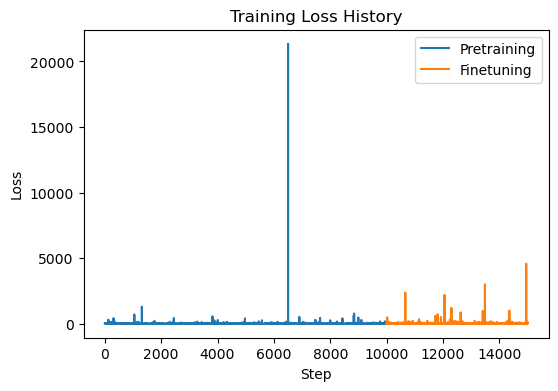

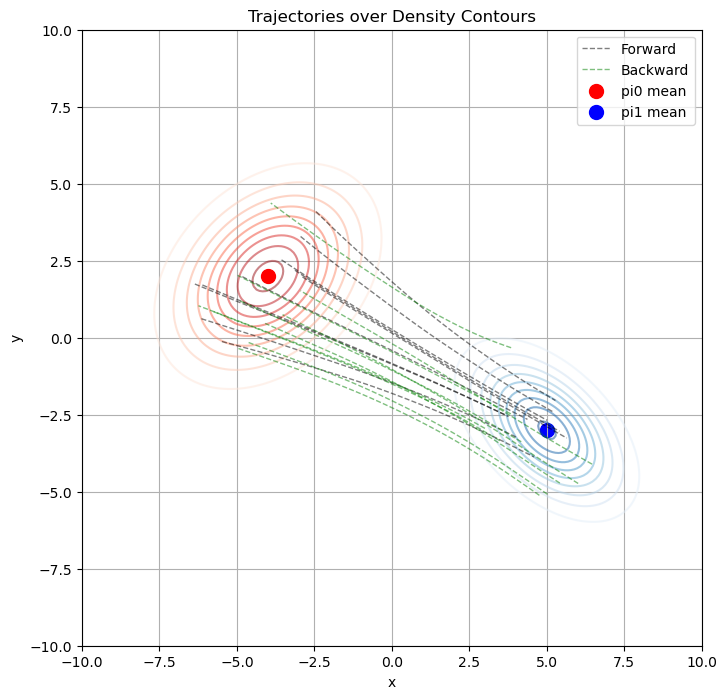

In [37]:
eps = 1.0         # Brownian bridge noise parameter
alpha_step = 1e-3 # Incremental gradient step for both stages
pretrain_steps = 10000
finetune_steps = 5000
batch_size = 256
ema_decay = 0.999

# Instantiate the bidirectional drift network
model = BidirectionalDriftNet(input_dim=4, hidden_dim=64, output_dim=2).to(device)
# Create an EMA copy of the model, start with the same parameters
ema_model = BidirectionalDriftNet(input_dim=4, hidden_dim=64, output_dim=2).to(device)
ema_model.load_state_dict(model.state_dict())

print("----- Pretraining Stage -----")
pretrain_loss = pretraining_stage(model, ema_model, num_steps=pretrain_steps, batch_size=batch_size, eps=eps, lr=1e-3, ema_decay=ema_decay)

print("----- Finetuning Stage -----")
finetune_loss = finetuning_stage(model, ema_model, num_steps=finetune_steps, batch_size=batch_size, eps=eps, lr=1e-4, alpha_step=alpha_step, ema_decay=ema_decay)

# Plot loss histories
plt.figure(figsize=(6,4))
plt.plot(pretrain_loss, label="Pretraining")
plt.plot(np.arange(len(pretrain_loss), len(pretrain_loss)+len(finetune_loss)), finetune_loss, label="Finetuning")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

# Visualize densities
# plot_density_contours()

# Visualize trajectories (bidirectional)
plot_trajectories(model, ema_model, eps=eps, num_steps=100, num_traj=10, use_ema=True)


## Mixture Distributions

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def sample_mixture(dist_params, batch_size):
    """
    dist_params: list of tuples (weight, mean, cov)
    For simplicity, we assume covariances are provided (as torch tensors) and are constant.
    """
    weights = np.array([w for w, m, cov in dist_params])
    comp = np.random.choice(len(dist_params), size=batch_size, p=weights/weights.sum())
    samples = []
    for idx in comp:
        _, mean, _ = dist_params[idx]
        sample = torch.randn(1, 2, device=device) + torch.tensor(mean, device=device)
        samples.append(sample)
    return torch.cat(samples, dim=0)

def sample_pi0(batch_size, params):
    return sample_mixture(params, batch_size)

def sample_pi1(batch_size, params):
    return sample_mixture(params, batch_size)

def mixture_density(x, dist_params):
    """
    Compute density at x for a mixture (assuming identity covariance)
    x: shape (N,2)
    Returns: density values (N,)
    """
    dens = np.zeros(x.shape[0])
    for w, mean, cov in dist_params:
        if isinstance(mean, torch.Tensor):
            mean = mean.cpu().numpy()
        if isinstance(cov, torch.Tensor):
            cov = cov.cpu().numpy()
        diff = np.array(x - mean)
        inv_cov = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        norm_const = 1.0 / (2 * np.pi * np.sqrt(det_cov))
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        dens += w * norm_const * np.exp(exponent)
    return dens

# ============================================================
# 2. Brownian Bridge Interpolant (Interp operator)
# ============================================================
def interp(x0, x1, t, eps=1.0):
    """
    Returns the Brownian bridge interpolation:
      x_t = (1-t)*x0 + t*x1 + sqrt(eps*t*(1-t))*z,
    with z ~ N(0,I)
    """
    x_linear = (1 - t) * x0 + t * x1
    noise_std = torch.sqrt(eps * t * (1 - t))
    z = torch.randn_like(x0)
    return x_linear + noise_std * z

# ============================================================
# 3. Bidirectional Drift Network v_theta(s, t, x)
# ============================================================
class BidirectionalDriftNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        """
        Input: concatenation of s (direction), t (time), and x (2D point).
        """
        super(BidirectionalDriftNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, s, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        inp = torch.cat([s, t, x], dim=1)  # shape [B,4]
        return self.net(inp)

# ============================================================
# 4. EMA Update Function
# ============================================================
def update_ema(model, ema_model, decay):
    with torch.no_grad():
        msd = model.state_dict()
        esd = ema_model.state_dict()
        for key in msd.keys():
            esd[key].mul_(decay).add_(msd[key] * (1 - decay))
        ema_model.load_state_dict(esd)

# ============================================================
# 5. Loss Functions with Loss Scaling (Bidirectional)
# ============================================================
def compute_bidirectional_loss(model, x0, x1, t, eps=1.0):
    # For pretraining we use the closed-form interpolant with original endpoints.
    # Forward branch (s=1)
    x_t = interp(x0, x1, t, eps)
    s_f = torch.ones_like(t, device=device)
    v_f = model(s_f, t, x_t)
    target_f = (x1 - x_t) / (1 - t)
    weight_fwd = 1 / (1 + eps * t / (1 - t + 1e-6))
    
    # Backward branch (s=0) - swap endpoints
    # x_t_b = interp(x0, x1, t, eps)
    s_b = torch.zeros_like(t, device=device)
    v_b = model(s_b, t, x_t)
    target_b = (x0 - x_t) / t
    weight_bwd = 1 / (1 + eps * (1 - t) / (t + 1e-6))
    
    loss_forward = (weight_fwd * ((v_f - target_f)**2)).mean()
    loss_backward = (weight_bwd * ((v_b - target_b)**2)).mean()
    return 0.5 * (loss_forward + loss_backward)

# ============================================================
# 6. Pretraining Stage
# ============================================================
def pretraining_stage(model, ema_model, num_steps=5000, batch_size=256, eps=1.0, lr=1e-3, ema_decay=0.999):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    for step in range(num_steps):
        x0 = sample_pi0(batch_size, pi0_params)
        x1 = sample_pi1(batch_size, pi1_params)
        t = torch.rand(batch_size, 1, device=device)
        loss = compute_bidirectional_loss(model, x0, x1, t, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(model, ema_model, ema_decay)
        loss_hist.append(loss.item())
        if (step+1) % 1000 == 0:
            print(f"[Pretraining] Step {step+1}/{num_steps}, Loss: {loss.item():.4f}")
    return loss_hist

# ============================================================
# 7. Finetuning Stage (Online Bidirectional Updates with SDE propagation)
# ============================================================
def euler_step(x, drift, dt):
    return x + drift * dt

def euler_maruyama_step(x, drift, dt, eps):
    noise = torch.randn_like(x) * np.sqrt(dt)
    return x + drift * dt + torch.sqrt(torch.tensor(eps, device=x.device)) * noise

def sample_forward_SDE(model, x0, num_steps=100, eps=1.0):
    """
    Simulate the forward SDE from x0 using Euler–Maruyama.
    SDE: dx = v_theta(1,t,x)*dt + sqrt(eps)*dB_t.
    Returns hat_x1.
    """
    dt = 1.0 / (num_steps - 1)
    x = x0.clone()
    s_val = torch.ones(x.shape[0], 1, device=device)  # forward: s=1
    ts = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1, 1)
    for t in ts[:-1]:
        drift = model(s_val, t.expand(x.shape[0], 1), x)
        x = euler_maruyama_step(x, drift, dt, eps)
    return x

def sample_backward_SDE(model, x1, num_steps=100, eps=1.0):
    """
    Simulate the backward SDE from x1 using Euler–Maruyama.
    SDE: dx = v_theta(0,t,x)*dt + sqrt(eps)*dB_t, with time reversed.
    Returns hat_x0.
    """
    dt = 1.0 / (num_steps - 1)
    x = x1.clone()
    s_val = torch.zeros(x.shape[0], 1, device=device)  # backward: s=0
    ts = torch.linspace(1.0, 0.0, num_steps, device=device).view(-1, 1)
    for t in ts[:-1]:
        drift = model(s_val, t.expand(x.shape[0], 1), x)
        x = euler_maruyama_step(x, drift, dt, eps)
    return x

def finetuning_stage(model, ema_model, num_steps=5000, batch_size=256, eps=1.0, lr=1e-4, 
                     alpha_step=1e-3, ema_decay=0.999, save_freq=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    saved_models = [deepcopy(ema_model.state_dict())]
    for step in range(num_steps):
        # Sample endpoints from mixture distributions
        x0 = sample_pi0(batch_size, pi0_params)
        x1 = sample_pi1(batch_size, pi1_params)
        
        # Propagate endpoints via SDEs:
        hat_x1 = sample_forward_SDE(model, x0, num_steps=100, eps=eps)
        hat_x0 = sample_backward_SDE(model, x1, num_steps=100, eps=eps)
        
        # For the forward branch:
        t_forward = torch.rand(batch_size, 1, device=device)
        x_t_forward = interp(hat_x0, x1, t_forward, eps)
        s_forward = torch.ones_like(t_forward, device=device)  # s=1 for forward branch
        v_forward = model(s_forward, t_forward, x_t_forward)
        target_forward = (x1 - x_t_forward) / (1 - t_forward)
        weight_forward = 1 / (1 + eps * t_forward / (1 - t_forward + 1e-6))
        
        # For the backward branch:
        # Interpolate between hat_x0 and x1 (use refined source from backward SDE)
        t_backward = torch.rand(batch_size, 1, device=device)
        x_t_backward = interp(x0, hat_x1, t_backward, eps)
        s_backward = torch.zeros_like(t_backward, device=device)  # s=0 for backward branch
        v_backward = model(s_backward, t_backward, x_t_backward)
        target_backward = (x0 - x_t_backward) / t_backward
        weight_backward = 1 / (1 + eps * (1 - t_backward) / (t_backward + 1e-6))
        
        loss_forward = (weight_forward * ((v_forward - target_forward)**2)).mean()
        loss_backward = (weight_backward * ((v_backward - target_backward)**2)).mean()
        loss = 0.5 * (loss_forward + loss_backward)
        
        optimizer.zero_grad()
        loss.backward()
        for param in model.parameters():
            param.grad.data.mul_(alpha_step)
        optimizer.step()
        update_ema(model, ema_model, ema_decay)
        loss_hist.append(loss.item())
        
        if (step+1) % 1000 == 0:
            print(f"[Finetuning] Step {step+1}/{num_steps}, Loss: {loss.item():.4f}")
        if (step+1) % save_freq == 0:    
            saved_models.append(deepcopy(ema_model.state_dict()))
            
    return loss_hist, saved_models

# ============================================================
# 8. Visualization: Plotting Saved Trajectories
# ============================================================
def sample_trajectory_bidirectional(model, s_value, x_init, num_steps=50, eps=1.0, use_noise=True):
    """
    Simulate a trajectory using Euler-Maruyama (if use_noise is True) or deterministic Euler (if False).
    s_value: tensor of shape [B,1] (1 for forward, 0 for backward).
    x_init: starting point tensor of shape [B,2]
    """
    ts = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1, 1)  # shape [num_steps,1]
    dt = 1.0 / (num_steps - 1)
    trajectory = []
    x = x_init.clone()  # starting point
    trajectory.append(x.detach().cpu().numpy())  # store as numpy array
    with torch.no_grad():
        for t in ts[:-1]:
            drift = model(s_value, t.expand(x.shape[0], 1), x)
            if use_noise:
                x = euler_maruyama_step(x, drift, dt, eps)
            else:
                x = euler_step(x, drift, dt)
            trajectory.append(x.detach().cpu().numpy())
    # Concatenate along the time dimension (resulting shape: [num_steps, 2])
    traj = np.concatenate(trajectory, axis=0)
    return traj

def plot_saved_trajectories(saved_models, model, num_steps=50, eps=1.0, num_traj=3, use_ema=True):
    traj_dict = {}
    for i, state in enumerate(saved_models):
        net = BidirectionalDriftNet(input_dim=4, hidden_dim=64, output_dim=2).to(device)
        net.load_state_dict(state)
        net.eval()
        traj_fwd_list = []
        traj_bwd_list = []
        for j in range(num_traj):
            x0_sample = sample_pi0(1, pi0_params)
            x1_sample = sample_pi1(1, pi1_params)
            traj_fwd = sample_trajectory_bidirectional(net, torch.ones(1,1, device=device), x0_sample, num_steps, eps, use_noise=False)
            traj_bwd = sample_trajectory_bidirectional(net, torch.zeros(1,1, device=device), x1_sample, num_steps, eps, use_noise=False)
            traj_fwd_list.append(traj_fwd)
            traj_bwd_list.append(traj_bwd)
        traj_dict[i] = {"forward": traj_fwd_list, "backward": traj_bwd_list}
    return traj_dict

def plot_trajectories_saved(traj_dict, nrows, save_freq):
    x = np.linspace(-8, 8, 200)
    y = np.linspace(-8, 8, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
    pi0_density = mixture_density(grid_points, pi0_params).reshape(X.shape)
    pi1_density = mixture_density(grid_points, pi1_params).reshape(X.shape)
    
    num_saved = len(traj_dict)
    ncols = (num_saved + nrows - 1) // nrows
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axs = np.array(axs).flatten()
    
    for i in range(num_saved):
        ax = axs[i]
        ax.contour(X, Y, pi0_density, levels=10, cmap='Reds', alpha=0.5)
        ax.contour(X, Y, pi1_density, levels=10, cmap='Blues', alpha=0.5)
        for traj in traj_dict[i]["forward"]:
            labels = ax.get_legend_handles_labels()[1]
            label = "Forward" if "Forward" not in labels else ""
            ax.plot(traj[:, 0], traj[:, 1], 'k--', alpha=0.5, lw=1, label=label)
            ax.scatter(traj[0, 0], traj[0, 1], color='red', s=20, alpha = 0.4)
            ax.scatter(traj[-1, 0], traj[-1, 1], color='blue', s=20, alpha = 0.4)
        for traj in traj_dict[i]["backward"]:
            labels = ax.get_legend_handles_labels()[1]
            label = "Backward" if "Backward" not in labels else ""
            ax.plot(traj[:, 0], traj[:, 1], 'g--', alpha=0.5, lw=1, label=label)
            ax.scatter(traj[0, 0], traj[0, 1], color='blue', s=20, alpha = 0.4)
            ax.scatter(traj[-1, 0], traj[-1, 1], color='red', s=20, alpha = 0.4)
        if(i==0):
            ax.set_title(f"Saved EMA Model after Pretraining Steps")
        else: 
            ax.set_title(f"Saved EMA Model at Finetuning Step {(i)*save_freq}")
        ax.legend()
        ax.grid(True)
    
    for j in range(num_saved, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

----- Pretraining Stage -----
[Pretraining] Step 1000/2000, Loss: 8.7169
[Pretraining] Step 2000/2000, Loss: 8.8550
----- Finetuning Stage -----
[Finetuning] Step 1000/9000, Loss: 0.6252
[Finetuning] Step 2000/9000, Loss: 0.4269
[Finetuning] Step 3000/9000, Loss: 0.2986
[Finetuning] Step 4000/9000, Loss: 0.3433
[Finetuning] Step 5000/9000, Loss: 0.2730
[Finetuning] Step 6000/9000, Loss: 0.3141
[Finetuning] Step 7000/9000, Loss: 0.2621
[Finetuning] Step 8000/9000, Loss: 0.2786
[Finetuning] Step 9000/9000, Loss: 0.2639


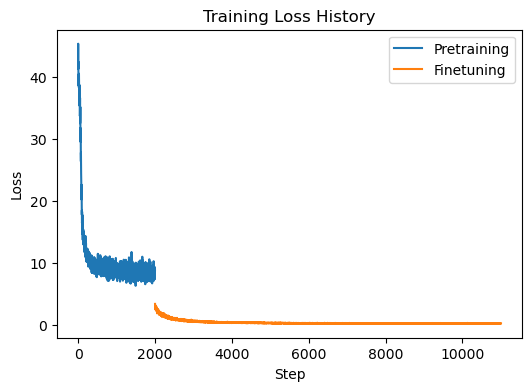

In [12]:
eps = 0.1         # Set bridge noise parameter
alpha_step = 1e-3 # Gradient scaling for incremental update
pretrain_steps = 2000
finetune_steps = 9000
batch_size = 256
ema_decay = 0.99

# Define mixture parameters for π₀ and π₁.
pi0_params = [
    (0.5, [-4, -4], torch.tensor([[1.0, -0.5], [-0.5, 1.0]], device=device)),
    (0.5, [-4, 4], torch.tensor([[1.0, -0.5], [-0.5, 1.0]], device=device))
]
pi1_params = [
    (0.5, [4, -4], torch.tensor([[1.0, 0.5], [0.5, 1.0]], device=device)),
    (0.5, [4, 4], torch.tensor([[1.0, 0.5], [0.5, 1.0]], device=device))
]

# Instantiate the bidirectional drift network and create its EMA copy.
model = BidirectionalDriftNet(input_dim=4, hidden_dim=64, output_dim=2).to(device)
ema_model = BidirectionalDriftNet(input_dim=4, hidden_dim=64, output_dim=2).to(device)
ema_model.load_state_dict(model.state_dict())

print("----- Pretraining Stage -----")
pretrain_loss = pretraining_stage(model, ema_model, num_steps=pretrain_steps, 
                                  batch_size=batch_size, eps=eps, lr=1e-3, ema_decay=ema_decay)

print("----- Finetuning Stage -----")
finetune_loss, saved_models = finetuning_stage(model, ema_model, num_steps=finetune_steps, 
                                               batch_size=batch_size, eps=eps, lr=1e-4, 
                                               alpha_step=alpha_step, ema_decay=ema_decay, save_freq=1000)

# Plot training loss history
plt.figure(figsize=(6,4))
plt.plot(pretrain_loss, label="Pretraining")
plt.plot(np.arange(len(pretrain_loss), len(pretrain_loss)+len(finetune_loss)), finetune_loss, label="Finetuning")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

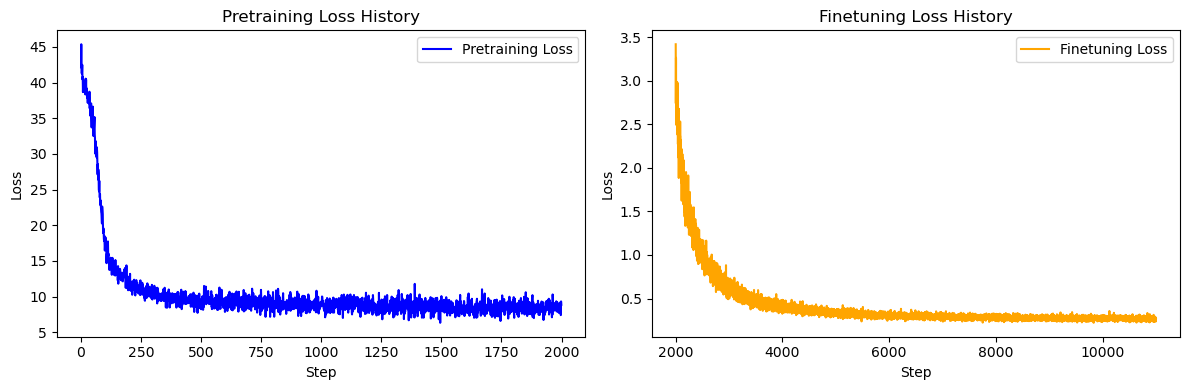

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(pretrain_loss, color='blue', label="Pretraining Loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].set_title("Pretraining Loss History")
axs[0].legend()

axs[1].plot(np.arange(len(pretrain_loss), len(pretrain_loss) + len(finetune_loss)),
            finetune_loss, color='orange', label="Finetuning Loss")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss")
axs[1].set_title("Finetuning Loss History")
axs[1].legend()

plt.tight_layout()
plt.show()

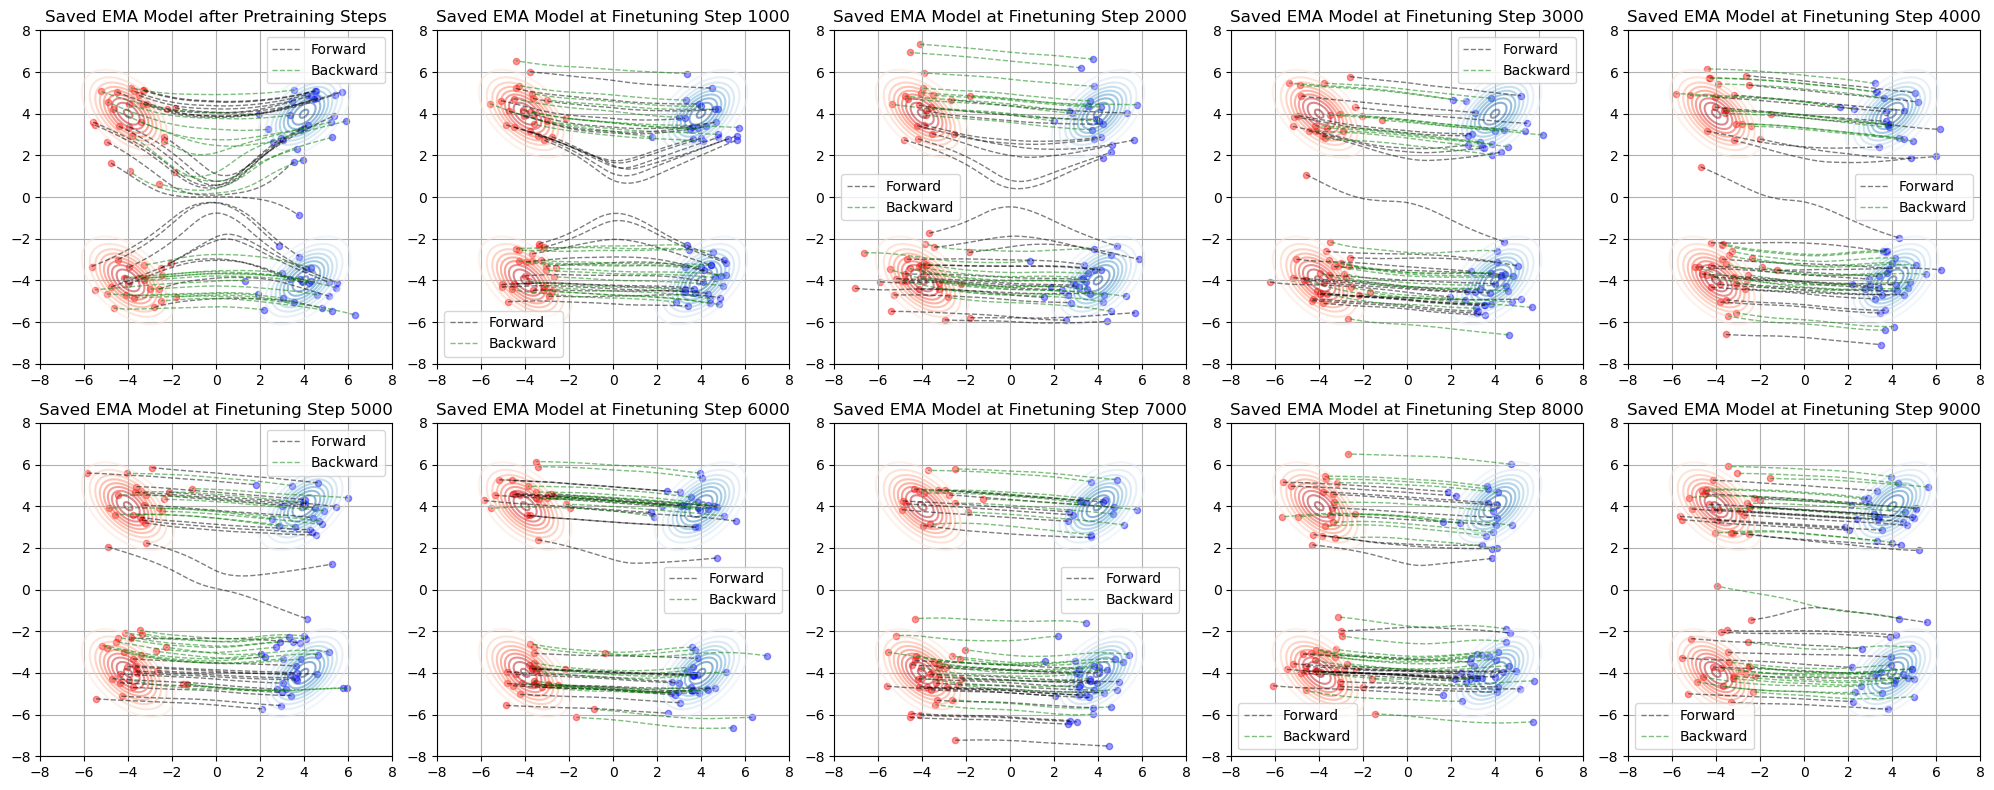

In [14]:
traj_dict = plot_saved_trajectories(saved_models, model, num_steps=100, eps=eps, num_traj=25, use_ema=True)
plot_trajectories_saved(traj_dict, nrows=2, save_freq=1000)